In [0]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

In [0]:
start = datetime.datetime(2010, 1, 1)
end = datetime.date.today()

In [0]:
df = web.DataReader("TSLA", 'yahoo', start, end)

In [9]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-30,232.440002,224.210007,229.149994,225.610001,9320600,225.610001
2019-09-03,228.949997,223.160004,224.080002,225.009995,5354100,225.009995
2019-09-04,228.460007,219.210007,226.889999,220.679993,5761000,220.679993
2019-09-05,229.800003,220.850006,222.500000,229.580002,7395300,229.580002
2019-09-06,229.639999,225.169998,227.199997,227.449997,4182200,227.449997


In [0]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

In [11]:
mavg.tail()

Date
2019-08-30    230.3739
2019-09-03    229.8634
2019-09-04    229.3860
2019-09-05    229.0048
2019-09-06    228.6155
Name: Adj Close, dtype: float64

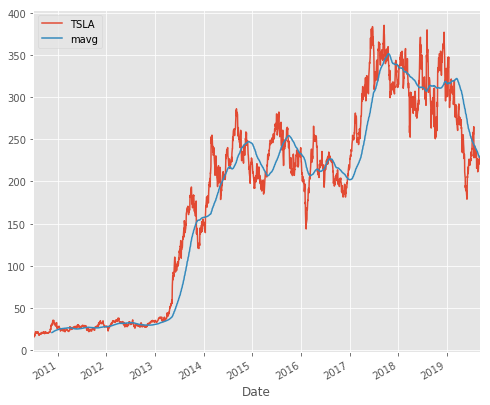

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

#Adjusting the siye of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8,7))
mpl.__version__

#Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='TSLA')
mavg.plot(label='mavg')
plt.legend()

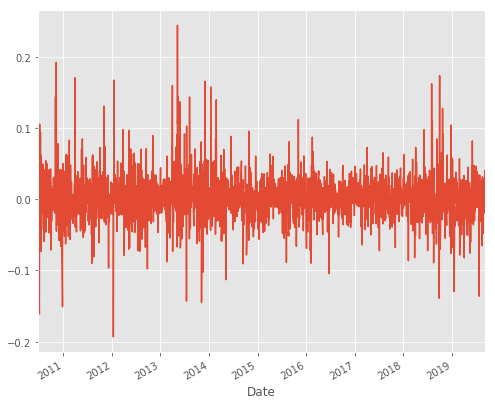

In [13]:
rets = close_px / close_px.shift(1)-1
rets.plot(label='return')

In [0]:
dfcomp = web.DataReader(['TSLA','BMWYY','VWAGY','DMLRY','GM','F'],'yahoo',start=start,end=end)['Adj Close']

In [15]:
dfcomp.tail()

Symbols,BMWYY,DMLRY,F,GM,TSLA,VWAGY
Date,,,,,,
2019-08-30,22.320000,11.69,9.17,36.721428,225.610001,16.250000
2019-09-03,22.100000,11.81,9.10,36.543217,225.009995,16.309999
2019-09-04,22.469999,12.11,9.20,37.860001,220.679993,16.594999
2019-09-05,22.879999,12.42,9.34,38.730000,229.580002,16.889999
2019-09-06,22.790001,12.42,9.34,38.779999,227.449997,16.809999


In [0]:
retscomp = dfcomp.pct_change()
corr = retscomp.corr()

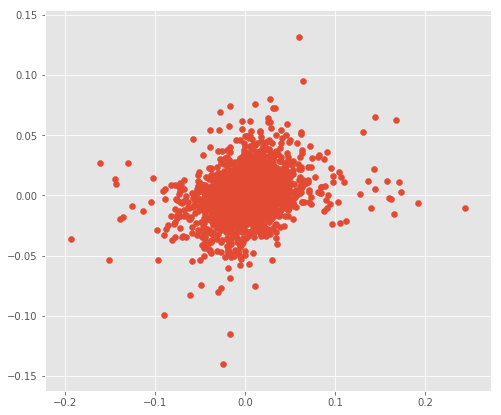

In [17]:
plt.scatter(retscomp.TSLA, retscomp.BMWYY)

In [18]:
retscomp.tail()

Symbols,BMWYY,DMLRY,F,GM,TSLA,VWAGY
Date,,,,,,
2019-08-30,0.005405,0.009499,0.005482,0.004877,0.017591,0.001356
2019-09-03,-0.009857,0.010265,-0.007634,-0.004853,-0.002659,0.003692
2019-09-04,0.016742,0.025402,0.010989,0.036034,-0.019244,0.017474
2019-09-05,0.018247,0.025599,0.015217,0.022979,0.040330,0.017776
2019-09-06,-0.003933,0.000000,0.000000,0.001291,-0.009278,-0.004737


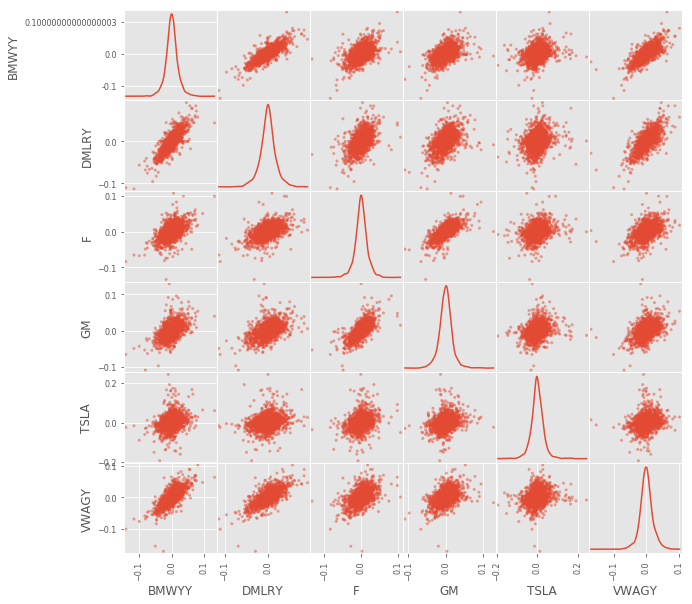

In [19]:
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10,10));

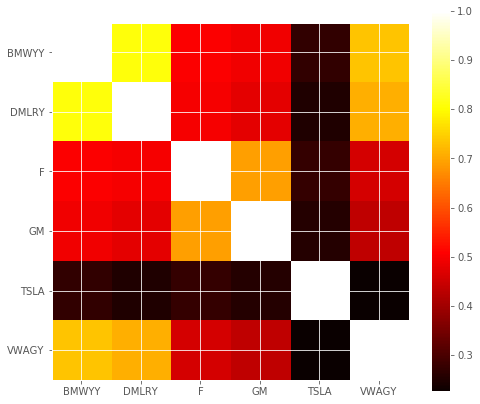

In [20]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

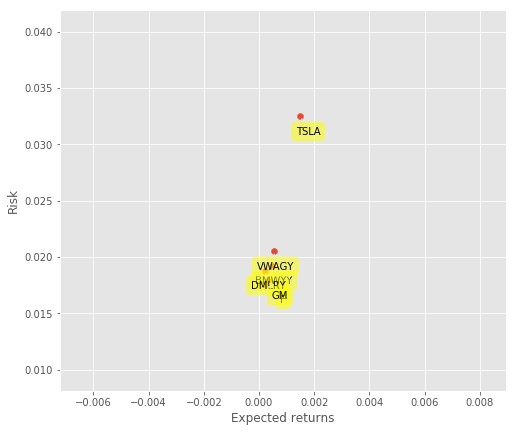

In [21]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
  plt.annotate(
  label,
  xy = (x,y), xytext = (20, -20),
  textcoords = 'offset points', ha = 'right', va = 'bottom',
  bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
  arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [0]:
# Feature Engineering

In [0]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [0]:
import math
import numpy as np
import sklearn

from sklearn import preprocessing

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)



In [62]:
len(X)

2290

In [63]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [64]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [0]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)


In [66]:
confidencereg

0.9463783327405274

In [67]:
confidencepoly2

0.9509487790488234

In [68]:
confidencepoly3

0.9490191245626951

In [69]:
confidenceknn

0.929064455103104

In [0]:
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan

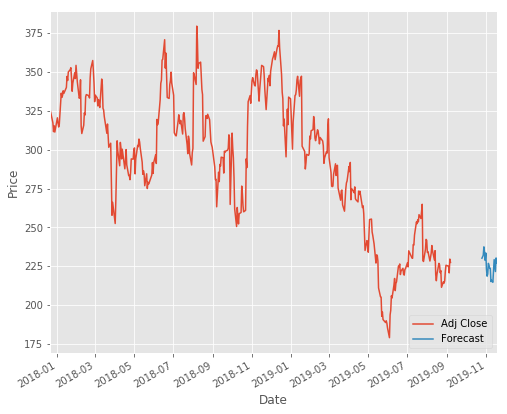

In [71]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()